Retrieves images from "raw_imgs" folder and stores them in "full_imgs". Retrieves spreadsheet listing VOIs and stores them in text file.

TODO: function to read existing vois, drop one class, then load the class back in. Requires that drm.load_imgs write to a DataFrame rather than an array

In [ ]:
# check e105370029_0 and e101346...

In [2]:
import config
import dr_methods as drm
import helper_fxns as hf
import transforms as tr
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyelastix
import time
%matplotlib inline

In [123]:
importlib.reload(hf)
importlib.reload(tr)
importlib.reload(config)
importlib.reload(drm)
C = config.Config()

In [67]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_art[voi_df_art["Filename"] == "12090000.npy"]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,real_dx,real_dy,real_dz,id,lesion_num
409,12090000.npy,88,117,156,181,44,55,colorectal,False,38.263888,32.98611,33.0,12090000_0,0


In [43]:
drm.load_all_vois(C)


Loading VOIs from sheet OPTN 5A
.................................................Overall time: 66.79371428489685

Loading VOIs from sheet OPTN 5B
................................Overall time: 40.85288429260254

Loading VOIs from sheet Cyst
.........................................Overall time: 64.83304619789124

Loading VOIs from sheet Hemangioma
......................................Overall time: 36.264217376708984

Loading VOIs from sheet FNH
.............................Overall time: 48.66874051094055

Loading VOIs from sheet Cholangio
............................................Overall time: 20.380342483520508

Loading VOIs from sheet Colorectal
...................................Overall time: 44.48308300971985


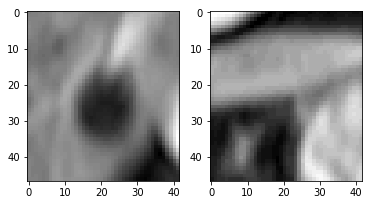

In [48]:
# can be used to determine if an image is flipped
cls = "cyst"
acc_num = '12042703'#acc_nums[0]
img_fn = acc_num + ".npy"
img = np.load(C.full_img_dir+"\\"+cls + "\\"+img_fn)
hf.plot_section(img, voi_df_art[voi_df_art["Filename"] == img_fn].iloc[0], flipz="both", pad=10)

In [72]:
voi_df_art[voi_df_art["id"] == "12859243_1"]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,real_dx,real_dy,real_dz,id,lesion_num
98,12859243.npy,65,83,137,156,46,56,cyst,False,19.125,20.1875,30.0,12859243_1,1


In [ ]:
[(float(row["real_dx"]) * float(row["real_dy"]) * float(row["real_dz"])) ** (1/3) / 50,
                            max(float(row["real_dx"]), float(row["real_dy"])) / float(row["real_dz"])]

In [16]:
#dims_df = pd.DataFrame(columns = ["AccNum", "x", "y", "z"])
dims_df = pd.read_csv(C.dims_df_path)
voi_df_art = pd.DataFrame(columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls",
                                     "flipz", "real_dx", "real_dy", "real_dz", "id", "lesion_num"])
voi_df_ven = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2"]) #voi_df_ven only contains entries where manually specified
voi_df_eq = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2"]) #voi_df_ven only contains entries where manually specified
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]

for cls in C.classes_to_include:
    if not os.path.exists(C.full_img_dir + "\\" + cls):
        os.makedirs(C.full_img_dir + "\\" + cls)
    
xls_name = 'Z:\\Prototype1d.xlsx'
base_dir = "Z:"

voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]
dims_df = pd.read_csv(C.dims_df_path)

In [73]:
#intensity_df = pd.read_csv(C.int_df_path)

intensity_df = drm.get_intensities(C)
intensity_df.to_csv(C.int_df_path, index=False)

for img_fn in os.listdir(C.full_img_dir):
    try:
        cls = voi_df_art[voi_df_art["Filename"] == img_fn]["cls"].values[0]
        os.rename(C.full_img_dir + "\\" + img_fn, C.full_img_dir + "\\" + cls + "\\" + img_fn)
    except:
        continue

In [63]:
#drm.delete_imgs(['12916368', 'E102556695'], 'hcc', C)
#drm.delete_imgs(0, cls, C, xls_name, sheetname)

### Run 1

In [74]:
img_dir = base_dir+'\\OPTN5A'
cls = 'hcc'
sheetname="OPTN 5A"

In [76]:
df = pd.read_excel(xls_name, sheetname)
df = drm.preprocess_df(df, C)
acc_nums = list(set(df['Patient E Number'].dropna().astype(str).tolist()))

In [120]:
patient_info_df = pd.DataFrame(columns = ["MRN", "Sex", "AccNum", "AgeAtImaging", "cls"])

In [124]:
img_dir = base_dir+'\\OPTN5A'
cls = 'hcc'
sheetname="OPTN 5A"
#drm.check_folders(img_dir, xls_name, sheetname, C)
#dims_df = drm.load_imgs(img_dir, cls, xls_name, sheetname, dims_df, C)
#voi_dfs = drm.load_vois(cls, xls_name, sheetname, voi_dfs, dims_df, C)
drm.load_patient_info(img_dir, cls, xls_name, sheetname, patient_info_df, C)


Loading DCMs of type OPTN 5A
.

FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\OPTN5A\\12972894\\T1_AP\\metadata.xml'

In [18]:
img_dir = base_dir+'\\optn5b'
cls = 'hcc'
sheetname="OPTN 5B"
#drm.check_folders(img_dir, xls_name, sheetname, C)
#dims_df = drm.load_imgs(img_dir, cls, xls_name, sheetname, dims_df, C)
voi_dfs = drm.load_vois(cls, xls_name, sheetname, voi_dfs, dims_df, C)


Loading VOIs for class hcc
................................Overall time: 41.466200828552246


In [19]:
img_dir = base_dir+'\\simple_cysts'
cls = 'cyst'
sheetname="Cyst"
#drm.check_folders(img_dir, xls_name, sheetname, C)
#dims_df = drm.load_imgs(img_dir, cls, xls_name, sheetname, dims_df, C)
voi_dfs = drm.load_vois(cls, xls_name, sheetname, voi_dfs, dims_df, C)


Loading VOIs for class cyst
.........................................Overall time: 61.250229358673096


In [20]:
img_dir = base_dir+'\\hemangioma'
cls = 'hemangioma'
sheetname="Hemangioma"
#drm.check_folders(img_dir, xls_name, sheetname, C)
#dims_df = drm.load_imgs(img_dir, cls, xls_name, sheetname, dims_df, C)
voi_dfs = drm.load_vois(cls, xls_name, sheetname, voi_dfs, dims_df, C)


Loading VOIs for class hemangioma
......................................Overall time: 37.37789702415466


In [24]:
voi_df_art, voi_df_ven, voi_df_eq = voi_dfs
voi_df_art.to_csv(C.art_voi_path, index=False)
voi_df_ven.to_csv(C.ven_voi_path, index=False)
voi_df_eq.to_csv(C.eq_voi_path, index=False)

In [121]:
dims_df.to_csv(C.dims_df_path, index=False)

In [ ]:
dims_df[dims_df["AccNum"] == "12530153"]

### Run 2

In [21]:
img_dir = base_dir+'\\fnh'
cls = 'fnh'
sheetname="FNH"
#drm.check_folders(img_dir, xls_name, sheetname, C)
#dims_df = drm.load_imgs(img_dir, cls, xls_name, sheetname, dims_df, C)
voi_dfs = drm.load_vois(cls, xls_name, sheetname, voi_dfs, dims_df, C)


Loading VOIs for class fnh
.............................Overall time: 45.90583872795105


In [22]:
img_dir = base_dir+'\\cholangio'
cls = 'cholangio'
sheetname="Cholangio"
#drm.check_folders(img_dir, xls_name, sheetname, C)
#dims_df = drm.load_imgs(img_dir, cls, xls_name, sheetname, dims_df, C)
voi_dfs = drm.load_vois(cls, xls_name, sheetname, voi_dfs, dims_df, C)


Loading VOIs for class cholangio
............................................Overall time: 22.865546464920044


In [23]:
img_dir = base_dir+'\\colorectal'
cls = 'colorectal'
sheetname="Colorectal"
#drm.check_folders(img_dir, xls_name, sheetname, C)
#dims_df = drm.load_imgs(img_dir, cls, xls_name, sheetname, dims_df, C)
voi_dfs = drm.load_vois(cls, xls_name, sheetname, voi_dfs, dims_df, C)


Loading VOIs for class colorectal
...................................Overall time: 44.72483015060425


In [40]:
dims_df[dims_df["AccNum"] == 'E101266931']

,AccNum,x,y,z


### Run 3

In [97]:
img_dir = base_dir+'\\adenoma'
cls = 'adenoma'
sheetname="Adenoma"
dims_df = drm.load_imgs(img_dir, cls, xls_name, sheetname, dims_df, C)
voi_dfs = drm.load_vois(cls, xls_name, sheetname, voi_dfs, dims_df, C)


Loading DCMs of type Adenoma
...............Overall time: 928.8483188152313


In [66]:
voi_df = hf.flipz(img_fn, voi_df)

In [ ]:
for img_fn in sorted(set(voi_df[voi_df["cls"] == "cyst"]['Filename'])):
    img = np.load("full_imgs\\"+img_fn)
    if np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,:img.shape[2]//3]) > \
            np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,(img.shape[2]+1)*2//3:]):
        print(img_fn)

In [ ]:
plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[1], pad=10)